In [7]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import random
from transformers import BertTokenizer, BertModel
import json
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [19]:
device = "cpu"

In [39]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

#### BiLSTM CRF model

In [43]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, batch_size=1, device='cpu'):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.target_size = target_size
        self.batch_size = batch_size
        self.device = device
        self.tag_to_ix = tag_to_ix
        self.start_tag = start_tag
        self.end_tag = end_tag

        self.embedding = nn.Embedding.from_pretrained(embedding_mat, freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)

        self.transitions_to = nn.Parameter(torch.randn(target_size, target_size)).to(device)
        self.transitions_to.data[start_tag, :] = -10000
        self.transitions_to.data[:, end_tag] = -10000

        # self.transitions_from = nn.Parameter(torch.randn(target_size, target_size))
        # self.transitions_from.data[:, start_tag] = -10000
        # self.transitions_from.data[end_tag, :] = -10000

        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(self.device),
                torch.randn(2, 1, self.hidden_dim // 2).to(self.device))

    def get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.embedding(sentence).view(len(sentence), 1, -1)
        #convert embeds to torch float32
        embeds = embeds.float()
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats


    def _forward_algo(self, lstm_features):

        scores = torch.full((1, self.target_size), -10000.).to(self.device)
        scores[0][self.start_tag] = 0.

        forward_var = scores

        for feat in lstm_features:
            next_tag_var = self.transitions_to + feat.view(-1, 1).expand(-1, self.target_size) + forward_var.expand(self.target_size, -1)
            max_score = next_tag_var.max(dim=1).values.view(-1, 1)
            next_tag_var = next_tag_var - max_score
            forward_var = (max_score + torch.logsumexp(next_tag_var, dim=1).view(-1, 1)).view(1, -1)
            
        terminal_var = forward_var + (self.transitions_to[self.end_tag]).view(1, -1)
        alpha = terminal_var
        max_score = alpha.max()
        alpha = max_score + torch.logsumexp(alpha - max_score, dim=1)
        return alpha
    

    def _score_sentence(self, lstm_features, tags):
        score = torch.zeros(1).to(self.device)
        tags = torch.cat([torch.tensor([self.tag_to_ix['START_TAG']], dtype=torch.long).to(self.device), tags]).to(self.device)
        for i, feat in enumerate(lstm_features):
            score += self.transitions_to[tags[i + 1], tags[i]] + feat[tags[i + 1]]
                
        score += self.transitions_to[self.tag_to_ix['END_TAG'], tags[-1]]
        return score
    
    def neg_log_likelihood(self, sentence, tags):
        lstm_feats = self.get_lstm_features(sentence)
        forward_score = self._forward_algo(lstm_feats)
        gold_score = self._score_sentence(lstm_feats, tags)
        return forward_score - gold_score
    

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.target_size), -10000.).to(self.device)
        init_vvars[0][self.start_tag] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = [] 
            viterbivars_t = [] 

            next_tag_var = self.transitions_to + forward_var.expand(self.target_size, -1)
            best_tag_id = torch.argmax(next_tag_var, dim=1)
            bptrs_t = best_tag_id
            viterbivars_t = next_tag_var[range(len(best_tag_id)), best_tag_id].view(1, -1)
            
            forward_var = (viterbivars_t + feat).view(1, -1)
            backpointers.append(bptrs_t)

        
        terminal_var = forward_var + self.transitions_to[self.end_tag]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

       
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id.item())
        
        start = best_path.pop()
        best_path.reverse()
        return path_score, best_path
        
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self.get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

        

In [8]:
train_data = json.load(open('../Dataset/NER_train.json', 'r'))
test_data = json.load(open('../Dataset/NER_test.json', 'r'))
val_data = json.load(open('../Dataset/NER_val.json', 'r'))

In [10]:
word_to_idx = {}

for case in train_data:
    for text in train_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in test_data:
    for text in test_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in val_data:
    for text in val_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

In [11]:
tag_to_ix = {}

for case in train_data:
    for tag in train_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in test_data:
    for tag in test_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in val_data:
    for tag in val_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix['START_TAG'] = len(tag_to_ix)
tag_to_ix['END_TAG'] = len(tag_to_ix)

#### Bert Embeddings

In [9]:
# tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
# bert_model = BertModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

In [10]:
# embedding_mat = np.zeros((len(word_to_idx), 768))

# for word, idx in tqdm(word_to_idx.items()):
#     # if word in tokenizer.vocab:
#     #     embedding_mat[idx] = bert_model(tokenizer.encode(word))[1].detach().numpy()
#     # else:
#     #     embedding_mat[idx] = np.random.rand(768)
#     try:
#         tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
#     except:
#         tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#         continue
#     embeddings = None
#     with torch.no_grad():
#         # outputs = bert_model(**tokens)
#         # embeddings = outputs.last_hidden_state
#         try:
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#         except:
#             tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#     embeddings = embeddings.squeeze(0)
#     word_embeddings = embeddings.mean(dim = 0)
#     embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

In [11]:
# pickle.dump(embedding_mat, open('Word Embeddings/legal_bert_embedding_mat.pkl', 'wb'))

In [13]:
embedding_mat = pickle.load(open('legal_bert_embedding_mat.pkl', 'rb'))

In [44]:
model = BiLSTM_CRF(len(word_to_idx), 768, 256, len(tag_to_ix), torch.tensor(embedding_mat).to(device), tag_to_ix['START_TAG'], tag_to_ix['END_TAG'], tag_to_ix, device=device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

EPOCHS = 10
train_loss = []
val_loss = []
train_macro_f1 = []
val_macro_f1 = []

for epoch in tqdm(range(EPOCHS), desc='Epoch'):
    loss = 0
    f1 = 0
    for i, case in tqdm(enumerate(train_data), desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        sentence = prepare_sequence(train_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(train_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        model.train(True)
        model.zero_grad()
        loss = model.neg_log_likelihood(sentence, tags)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        with torch.no_grad():
            preds = model(sentence)[1]
            tags = tags.cpu().numpy()
            f1 += f1_score(tags, preds, average='macro')
    
    train_loss.append(loss/len(train_data))
    train_macro_f1.append(f1/len(train_data))
    
    model.eval()
    with torch.no_grad():
        loss = 0
        f1 = 0
        for case in val_data:
            sentence = prepare_sequence(val_data[case]['text'].split(' '), word_to_idx)
            tags = prepare_sequence(val_data[case]['labels'], tag_to_ix)
            setence = sentence.to(device)
            tags = tags.to(device)
            loss = model.neg_log_likelihood(sentence, tags)
            loss += loss.item()
            preds = model(sentence)[1]
            f1 += f1_score(tags.cpu().numpy(), preds, average='macro')
        val_macro_f1.append(f1/len(val_data))
        val_loss.append(loss/len(val_data))

    print()
    print(f'Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}')
    print(f'Train macro f1: {train_macro_f1[-1]}, Val macro f1: {val_macro_f1[-1]}')
    print(f'Epoch {epoch + 1}/{EPOCHS} done')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.save(model, 'saved models/10_epochs_unfreeze_legalbert.pt')

In [ ]:
pickle.dump(train_loss, open('Losses/10_epochs_unfreeze_train_loss.pkl', 'wb'))
pickle.dump(val_loss, open('Losses/10_epochs_unfreeze_val_loss.pkl', 'wb'))
pickle.dump(train_macro_f1, open('Macro_F1/10_epochs_unfreeze_train_macro_f1.pkl', 'wb'))
pickle.dump(val_macro_f1, open('Macro_F1/10_epochs_unfreeze_val_macro_f1.pkl', 'wb'))

In [ ]:
train_loss = pickle.load(open('Losses/10_epochs_train_loss.pkl', 'rb'))
val_loss = pickle.load(open('Losses/10_epochs_val_loss.pkl', 'rb'))
train_macro_f1 = pickle.load(open('Macro_F1/10_epochs_train_macro_f1.pkl', 'rb'))
val_macro_f1 = pickle.load(open('Macro_F1/10_epochs_val_macro_f1.pkl', 'rb'))

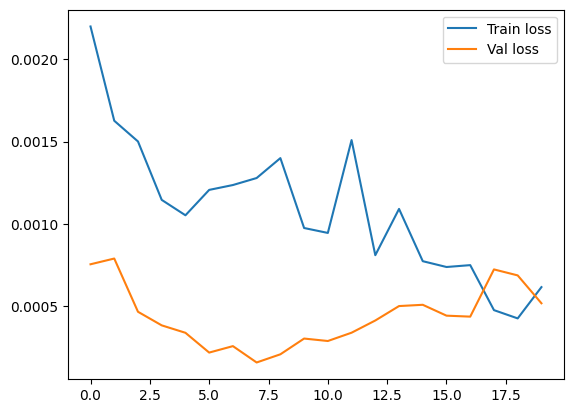

In [ ]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

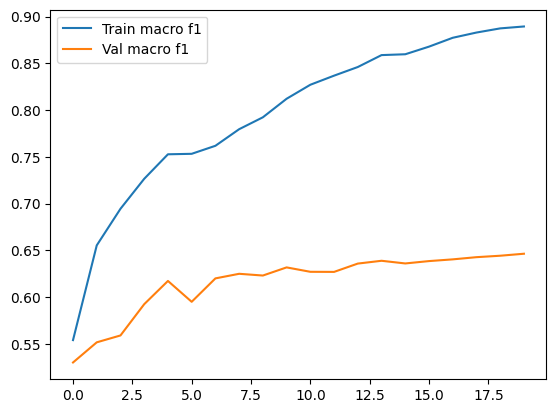

In [ ]:
train_f1 = [i.item() for i in train_macro_f1]
val_f1 = [i.item() for i in val_macro_f1]

plt.plot(train_f1, label='Train macro f1')
plt.plot(val_f1, label='Val macro f1')
plt.legend()
plt.show()

In [ ]:
model = torch.load('saved models/t1_model4_legalbert.pt')

In [28]:
model.eval()
with torch.no_grad():
    f1 = 0
    for case in test_data:
        sentence = prepare_sequence(test_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(test_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        preds = model(sentence)[1]
        tags = tags.cpu().numpy()
        f1 += f1_score(tags, preds, average='macro')
    print(f'Test macro f1: {f1/len(test_data)}')

Test macro f1: 0.6394855470162469
